In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-5.10.123+-x86_64-with-debian-bullseye-sid


In [2]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False


   
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.4


In [3]:
MyDrive = '/kaggle/working'

PROJECT_DIR = '../input/real-life-violence-situations-dataset'
!ls {PROJECT_DIR}

'Real Life Violence Dataset'  'real life violence situations'


In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [5]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)
            # 0 350
            # 500 800

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [02:25<00:00,  2.41it/s]

CPU times: user 5min 47s, sys: 15.3 s, total: 6min 2s
Wall time: 3min 40s


In [6]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

13583

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [8]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [9]:
epochs = 150

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)



def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = tf.keras.applications.ResNet50(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = True 

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model


model = load_layers()

model.summary()

2022-07-07 09:37:46.899370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 09:37:47.016902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 09:37:47.017924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 09:37:47.019342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step
Compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________

In [10]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [11]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

2022-07-07 09:37:51.703641: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-07 09:37:51.703678: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-07 09:37:51.705489: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-07-07 09:37:51.835967: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-07 09:37:51.836151: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [12]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...


2022-07-07 09:37:53.271552: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1869348864 exceeds 10% of free system memory.
2022-07-07 09:37:55.254374: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1869348864 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-07-07 09:37:56.723076: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-07-07 09:38:02.355932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/2377 [..............................] - ETA: 7:34:45 - loss: 0.8148 - accuracy: 0.5000

2022-07-07 09:38:08.387400: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-07 09:38:08.387448: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2377 [..............................] - ETA: 15:22 - loss: 0.7321 - accuracy: 0.6250  

2022-07-07 09:38:08.664324: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-07 09:38:08.666116: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-07 09:38:08.809607: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1321 callback api events and 1318 activity events. 
2022-07-07 09:38:08.844861: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   5/2377 [..............................] - ETA: 8:04 - loss: 0.7805 - accuracy: 0.5500 

2022-07-07 09:38:08.891096: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20220707-093751/train/plugins/profile/2022_07_07_09_38_08

2022-07-07 09:38:08.916287: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20220707-093751/train/plugins/profile/2022_07_07_09_38_08/cae8d118555a.trace.json.gz
2022-07-07 09:38:08.979984: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20220707-093751/train/plugins/profile/2022_07_07_09_38_08

2022-07-07 09:38:08.987592: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20220707-093751/train/plugins/profile/2022_07_07_09_38_08/cae8d118555a.memory_profile.json.gz
2022-07-07 09:38:08.989999: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/fit/20220707-093751/train/plugins/profile/2022_07_07_09_38_08
D

2377/2377 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8132

2022-07-07 09:39:22.507416: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 801177600 exceeds 10% of free system memory.
2022-07-07 09:39:23.575990: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 801177600 exceeds 10% of free system memory.


2377/2377 [==============================] - 99s 37ms/step - loss: 0.3957 - accuracy: 0.8132 - val_loss: 0.4435 - val_accuracy: 0.9026

Epoch 00001: val_loss improved from inf to 0.44353, saving model to ModelWeights.h5


2022-07-07 09:39:37.279186: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 283115520 exceeds 10% of free system memory.


Epoch 2/150
2377/2377 [==============================] - 83s 35ms/step - loss: 0.1998 - accuracy: 0.9211 - val_loss: 0.3212 - val_accuracy: 0.9337

Epoch 00002: val_loss improved from 0.44353 to 0.32123, saving model to ModelWeights.h5
Epoch 3/150
2377/2377 [==============================] - 82s 35ms/step - loss: 0.1040 - accuracy: 0.9616 - val_loss: 0.2141 - val_accuracy: 0.9453

Epoch 00003: val_loss improved from 0.32123 to 0.21408, saving model to ModelWeights.h5
Epoch 4/150
2377/2377 [==============================] - 83s 35ms/step - loss: 0.0700 - accuracy: 0.9760 - val_loss: 0.1579 - val_accuracy: 0.9448

Epoch 00004: val_loss improved from 0.21408 to 0.15791, saving model to ModelWeights.h5
Epoch 5/150
2377/2377 [==============================] - 83s 35ms/step - loss: 0.0590 - accuracy: 0.9793 - val_loss: 0.1469 - val_accuracy: 0.9553

Epoch 00005: val_loss improved from 0.15791 to 0.14691, saving model to ModelWeights.h5
Epoch 6/150
2377/2377 [==============================] -

In [13]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)  

------------------------------------------------------------------------------------------
Best Epochs:  5
Accuracy on train: 0.9799116253852844 	Loss on train: 0.058809176087379456
Accuracy on test: 0.9788957238197327 	Loss on test: 0.062127549201250076


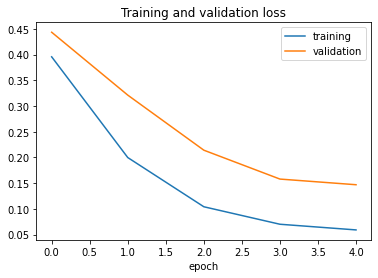

<Figure size 432x288 with 0 Axes>

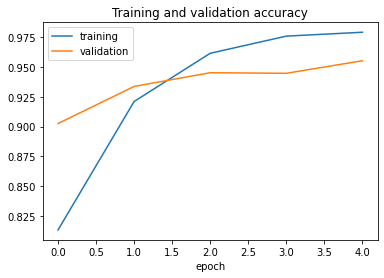

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [14]:
model_summary(model, history)

In [15]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


> Correct Predictions: 3989
> Wrong Predictions: 86


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

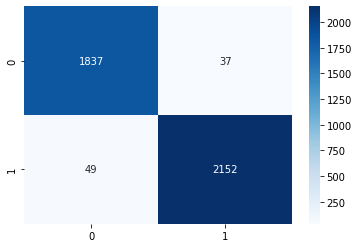

              precision    recall  f1-score   support

 NonViolence       0.97      0.98      0.98      1874
    Violence       0.98      0.98      0.98      2201

    accuracy                           0.98      4075
   macro avg       0.98      0.98      0.98      4075
weighted avg       0.98      0.98      0.98      4075



In [16]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [17]:
model.save("./ResNet50.hdf5")


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
